<a href="https://colab.research.google.com/github/zzhang007/test/blob/master/Test_Neeuro_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before we start, first install the necessary libraries.

In [ ]:
# Install toolboxes
!pip install mne

Then import the necessary libraries.

In [ ]:
# Import libraries
import mne
import matplotlib
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio

Examine the files in the working directory

In [ ]:
!ls

Close_20220408-104259_NeeuroSenze_3.cnt  CNTEEG.py    sample_data
Close_20220408-105454_Muse2016Ble_3.cnt  __pycache__


# 1. Load the Neeuro SenzeBand EEG data files

Stimcode:  [200 100  -1]
Stimpos:  [  945 33087 63169]
Channels:  ['FP1', 'FP2', 'T10', 'T9']
Sampling rate:  250


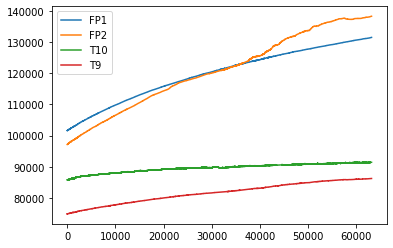

In [ ]:
from CNTEEG import ContEEG

raweeg = ContEEG()
raweeg.ReadContEEG('Close_20220408-104259_NeeuroSenze_3.cnt')
print('Stimcode: ',raweeg.stimcode)
print('Stimpos: ',raweeg.stimpos)
ch_names=raweeg.chan_list.tolist()
print('Channels: ',ch_names)
print('Sampling rate: ',raweeg.sampling_rate)
eegdata=raweeg.eeg.transpose()
sfreq = raweeg.sampling_rate
ax = plt.subplots(1)[1]
plt.plot(eegdata[0,:])
plt.plot(eegdata[1,:])
plt.plot(eegdata[2,:])
plt.plot(eegdata[3,:])
ax.legend(ch_names, loc ="upper left")


The above plot shows a **DC drift** issue in FP1 and FP2. Now we perform a digital reference to (T10+T9)/2

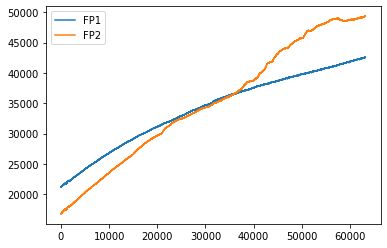

In [ ]:
eegdata[0,:]=eegdata[0,:]-((eegdata[2,:]+eegdata[3,:])/2)
eegdata[1,:]=eegdata[1,:]-((eegdata[2,:]+eegdata[3,:])/2)
ax = plt.subplots(1)[1]
plt.plot(eegdata[0,:])
plt.plot(eegdata[1,:])
ax.legend(ch_names[0:2], loc ="upper left")

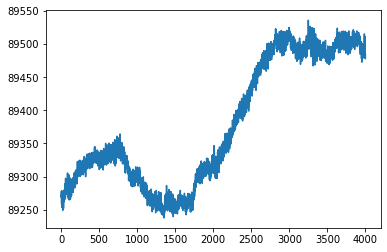

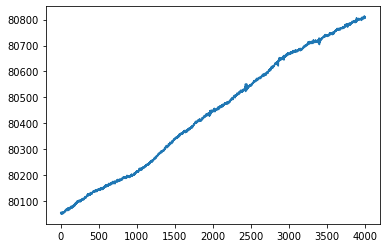

In [ ]:
timeseg=np.arange(20000,24000)
fig1, ax1 = plt.subplots()
fig=plt.plot(eegdata[2,timeseg])
fig2, ax2 = plt.subplots()
fig=plt.plot(eegdata[3,timeseg])


The above plot shows an eye blink, which shows up in TP10, but not in TP9.

In [ ]:
info = mne.create_info(ch_names = ch_names[0:2], sfreq = sfreq, ch_types=['eeg','eeg'])
raweeg = mne.io.RawArray(eegdata[0:2,:], info)

Creating RawArray with float64 data, n_channels=2, n_times=63170
    Range : 0 ... 63169 =      0.000 ...   252.676 secs
Ready.



IIR filter parameters
---------------------
Chebyshev I highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Cutoff at 0.50 Hz: -0.20 dB



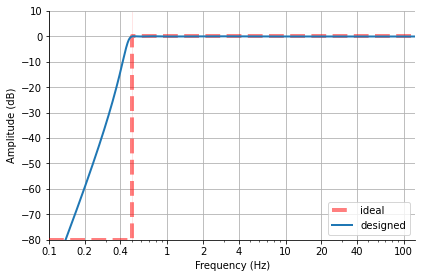

In [ ]:
sfreq = sfreq=raweeg.info['sfreq']
f_p = 0.5
f_s = 0.4
# Ideal filter parameters
freq = [0, f_p, f_p, sfreq / 2]
gain = [0, 0, 1, 1]
# Design filter
filter_params = dict(ftype='cheby1', gpass=0.1, gstop=10, output='sos')  
filter_params = mne.filter.construct_iir_filter(filter_params, f_pass=f_p, f_stop=f_s, sfreq=sfreq, btype='highpass') 
# Plot ideal and design filters
ax = plt.subplots(1)[1]
fig=mne.viz.plot_ideal_filter(freq, gain, show=False, flim=(0.1, 100), axes=ax)
fig=mne.viz.plot_filter(filter_params,sfreq=250,plot='magnitude',show=False,axes=ax)
ax.legend(["ideal", "designed"], loc ="lower right")

Filtering raw data in 1 contiguous segment
Using matplotlib as 2D backend.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


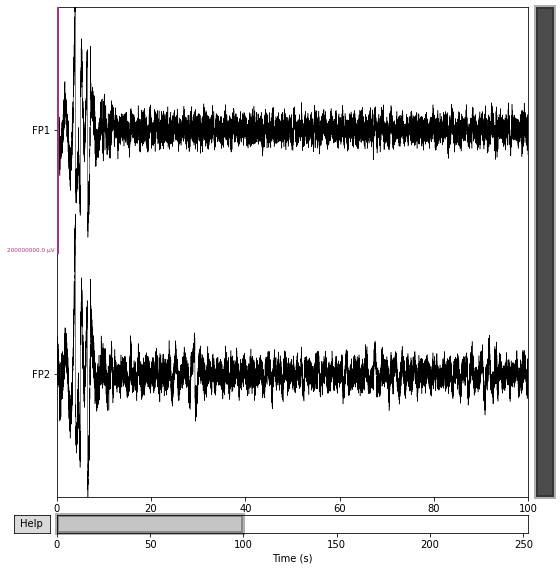

In [ ]:
filtereeg=raweeg.copy()
filtereeg.filter(l_freq=None,h_freq=None,method='iir',iir_params=filter_params)
fig=filtereeg.plot(start=0,duration=100,n_channels=2,scalings=100)


IIR filter parameters
---------------------
Chebyshev I bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Cutoffs at 8.00, 12.00 Hz: -0.60, -0.60 dB



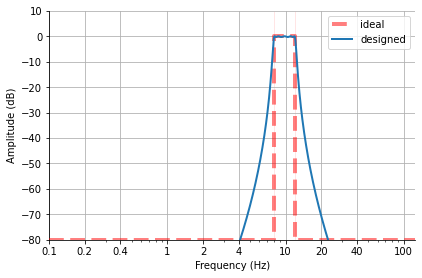

In [ ]:
sfreq = sfreq=raweeg.info['sfreq']
f_p = [8,12]
f_a = 2
f_s = [f_p[0]-f_a,f_p[1]+f_a]
# Ideal filter parameters
freq = [0, f_p[0], f_p[0], f_p[1], f_p[1], sfreq / 2]
gain = [0, 0, 1, 1, 0, 0]
# Design filter
filter_params = dict(ftype='cheby1', gpass=0.3, gstop=30, output='sos')  
filter_params = mne.filter.construct_iir_filter(filter_params, f_pass=f_p, f_stop=f_s, sfreq=sfreq, btype='bandpass') 
# Plot ideal and design filters
ax = plt.subplots(1)[1]
fig=mne.viz.plot_ideal_filter(freq, gain, show=False, flim=(0.1, 100), axes=ax)
fig=mne.viz.plot_filter(filter_params,sfreq=sfreq,plot='magnitude',show=False,axes=ax)
ax.legend(["ideal", "designed"], loc ="upper right")

Now we filter the data using alpha bandpass

Filtering raw data in 1 contiguous segment
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


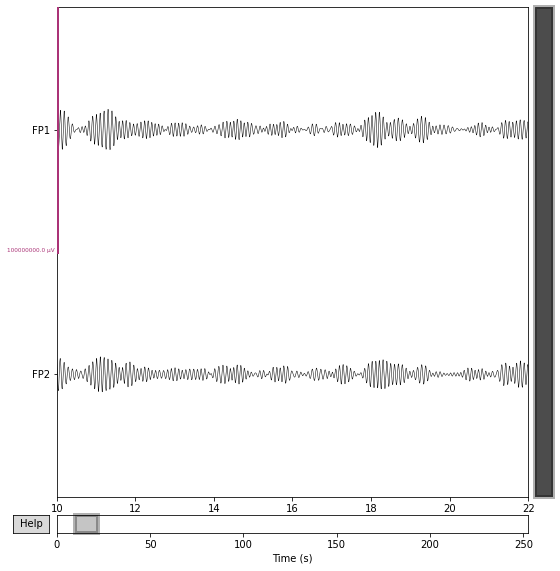

In [ ]:
filtereeg=raweeg.copy()
filtereeg.filter(l_freq=None,h_freq=None,method='iir',iir_params=filter_params)
fig=filtereeg.plot(start=10,duration=12,n_channels=2,scalings=50)

The above shows alpha waves in eyes close condition

Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


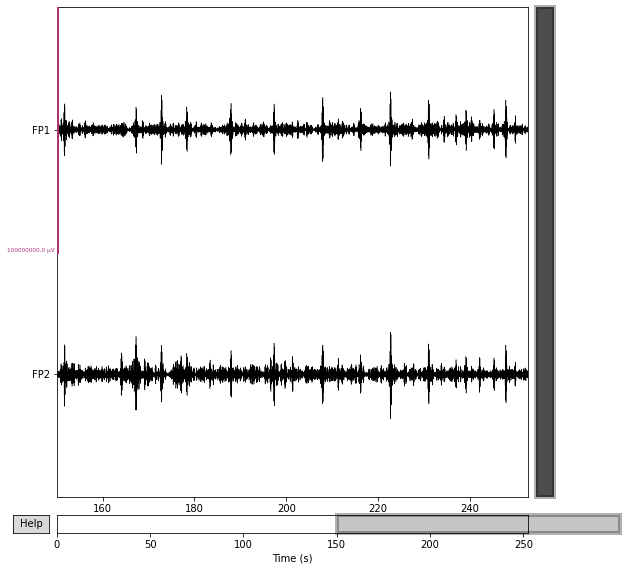

In [ ]:
fig=filtereeg.plot(start=150,duration=152,n_channels=2,scalings=50)

#2. Load the Muse data

Stimcode:  [200 100  -1]
Stimpos:  [  540 32772 63491]
Channels:  ['TP9', 'FP1', 'FP2', 'TP10']
Sampling rate:  256


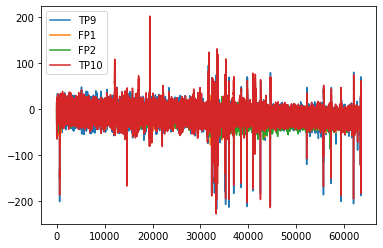

In [ ]:
raweeg = ContEEG()
raweeg.ReadContEEG('Close_20220408-105454_Muse2016Ble_3.cnt')
print('Stimcode: ',raweeg.stimcode)
print('Stimpos: ',raweeg.stimpos)
ch_names=raweeg.chan_list.tolist()
print('Channels: ',ch_names)
print('Sampling rate: ',raweeg.sampling_rate)
eegdata=raweeg.eeg.transpose()
sfreq = raweeg.sampling_rate
ax = plt.subplots(1)[1]
plt.plot(eegdata[0,:])
plt.plot(eegdata[1,:])
plt.plot(eegdata[2,:])
plt.plot(eegdata[3,:])
ax.legend(ch_names, loc ="upper left")


There is no DC drifts. Now we perform a digital reference to (TP9+TP10)/2

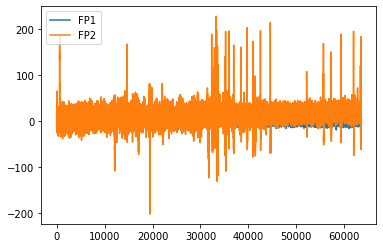

In [ ]:
eegdata[1,:]=eegdata[0,:]-((eegdata[0,:]+eegdata[3,:])/2)
eegdata[2,:]=eegdata[1,:]-((eegdata[0,:]+eegdata[3,:])/2)
ax = plt.subplots(1)[1]
plt.plot(eegdata[1,:])
plt.plot(eegdata[2,:])
ax.legend(ch_names[1:3], loc ="upper left")

The above plots referenced FP1 and FP2

In [ ]:
info = mne.create_info(ch_names = ch_names[1:3], sfreq = sfreq, ch_types=['eeg','eeg'])
raweeg = mne.io.RawArray(eegdata[1:3,:], info)

Creating RawArray with float64 data, n_channels=2, n_times=63492
    Range : 0 ... 63491 =      0.000 ...   248.012 secs
Ready.



IIR filter parameters
---------------------
Chebyshev I bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Cutoffs at 8.00, 12.00 Hz: -0.60, -0.60 dB



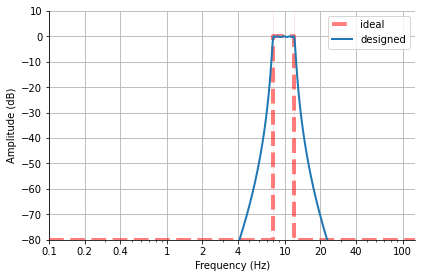

In [ ]:
sfreq = sfreq=raweeg.info['sfreq']
f_p = [8,12]
f_a = 2
f_s = [f_p[0]-f_a,f_p[1]+f_a]
# Ideal filter parameters
freq = [0, f_p[0], f_p[0], f_p[1], f_p[1], sfreq / 2]
gain = [0, 0, 1, 1, 0, 0]
# Design filter
filter_params = dict(ftype='cheby1', gpass=0.3, gstop=30, output='sos')  
filter_params = mne.filter.construct_iir_filter(filter_params, f_pass=f_p, f_stop=f_s, sfreq=sfreq, btype='bandpass') 
# Plot ideal and design filters
ax = plt.subplots(1)[1]
fig=mne.viz.plot_ideal_filter(freq, gain, show=False, flim=(0.1, 100), axes=ax)
fig=mne.viz.plot_filter(filter_params,sfreq=sfreq,plot='magnitude',show=False,axes=ax)
ax.legend(["ideal", "designed"], loc ="upper right")

Filtering raw data in 1 contiguous segment
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


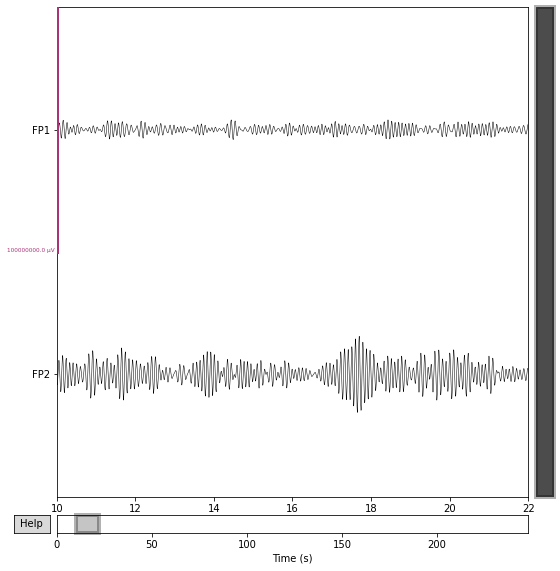

In [ ]:
filtereeg=raweeg.copy()
filtereeg.filter(l_freq=None,h_freq=None,method='iir',iir_params=filter_params)
fig=filtereeg.plot(start=10,duration=12,n_channels=2,scalings=50)

The above shows alpha waves in eyes close condition

Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


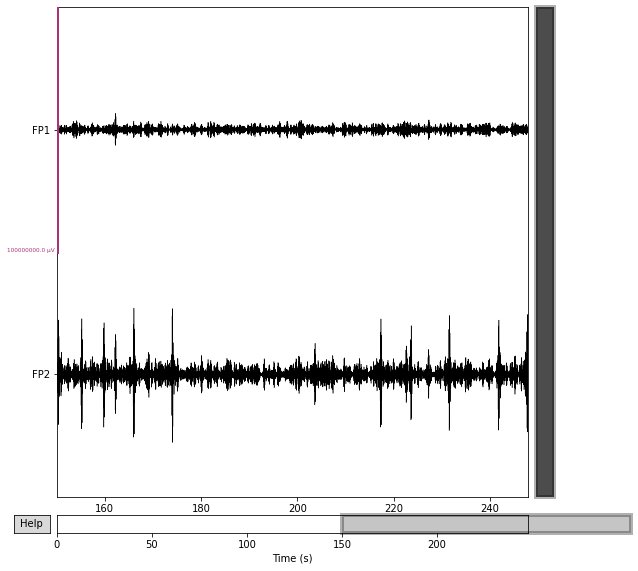

In [ ]:
fig=filtereeg.plot(start=150,duration=152,n_channels=2,scalings=50)

The above shows no alpha waves in eyes open condition